In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.8/872.8 kB 10.0 MB/s eta 0:00:00


In [ ]:
import cv2 as cv
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torchvision
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import torch.optim.lr_scheduler as lr_scheduler
from ultralytics import YOLO

In [ ]:
FACE_DETECTOR_ROOT = '/content/best_face_detector.pt'
PROBLEMATIC_EMOTIONS_CLASSIFIER = '/content/resnet_model_with_problematic.pt'
EMOTIONS_CLASSIFIER = '/content/resnet_model_with_problematic.pt'

In [ ]:
face_detector = YOLO(FACE_DETECTOR_ROOT)

In [ ]:
def find_faces(img_path: str,face_detector: YOLO, threshold: int = 0.5) -> list:

  """

  Returns location of faces detected on image with path {img_path}

  """


  # AKO IMA POJKE SLIKI VO DICT KEY DA E IMETO VALUE DA E LISTA SO SLIKI
  #faces_dict = {}

  #full_path = '/content/' + path
  img = cv.imread(img_path)
  #plt.imshow(img)
  #plt.show()
  predictions = face_detector(img_path)[0]
  faces = []
  face_locations = dict()
  for index,prediction in enumerate(predictions.boxes.data.tolist()):
    x1,y1,x2,y2,score,class_id = prediction
    if score > threshold:
      face = img[int(y1):int(y2),int(x1):int(x2)]
      faces.append(face)
      face_locations[img_path + str(index)] = [x1,x2,y1,y2]
      #plt.imshow(face)
      #plt.show()
      # cv.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
      # cv.putText(img, results.names[int(class_id)].upper() + f' {score}', (int(x1), int(y1 - 10)),
      #                   cv.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv.LINE_AA)

  # DODAVANJE VO DICT AKO IMA POJKE SLIKI
  #faces_dict[img_path] = faces
  return faces, face_locations

In [ ]:
temp = find_faces('/content/people1.jpg',face_detector)


image 1/1 /content/people1.jpg: 448x640 9 faces, 151.4ms
Speed: 3.3ms preprocess, 151.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, hidden_units, stride = 1, downsample = None) -> None:
    super().__init__()

    self.first_conv_block = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size = 3, stride = stride, padding = 1),
        nn.Dropout(0.25),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU()
    )

    self.second_conv_block = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels = hidden_units, kernel_size = 3, padding =1 ,stride = 1 ),
        nn.BatchNorm2d(hidden_units)
    )

    self.relu = nn.ReLU()

    self.downsample = downsample

  def forward(self, x : torch.Tensor) -> torch.Tensor:

    # make data copy
    input = x

    x = self.first_conv_block(x)
    x = self.second_conv_block(x)

    if self.downsample:

      # transform residual if activ. function is added
      input = self.downsample(input)

    # add residual to conv blocks

    x+=input

    x = self.relu(x)
    return x

In [ ]:
class ResNet(nn.Module):

  def __init__(self,input_shape: int,block_type : nn.Module, layer_sizes: list, num_of_classes: int = 9, inplanes: int = 64 ) -> None:
    super().__init__()

    self.inplanes = inplanes

    self.first_conv = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels = inplanes, kernel_size= 7, stride = 2),
        nn.Dropout(0.25),
        nn.BatchNorm2d(inplanes),
        nn.ReLU()
    )

    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.avgpool = nn.AvgPool2d(2, stride=1)

    self.layer1 = self._build_block(block_type, inplanes, layer_sizes[0], False, stride =1)
    self.layer2 = self._build_block(block_type, 128, layer_sizes[1], True, stride=2)
    self.layer3 = self._build_block(block_type, 256, layer_sizes[2], True, stride = 2)
    self.layer4 = self._build_block(block_type, 512, layer_sizes[3], True, stride = 2)

    self.output_layer =nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=512,out_features = num_of_classes),
    )

    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)

  def _build_block(self,block_type: nn.Module, out_planes:int, num_of_blocks:int,contain_downsample:bool = False, stride:int =1) -> nn.Module:

    downsample = None

    # if residual should go through function
    if stride != 1 or self.inplanes != out_planes:
      downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, out_planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_planes),
            )

    # layers of residual block will be added here
    layers = []

    # first layer with input size = to output of previous layer
    layers.append(block_type(self.inplanes, out_planes, stride, downsample))
    # change to output
    self.inplanes = out_planes

    # add remaining layers
    for i in range(1,num_of_blocks):
      layers.append(block_type(self.inplanes,out_planes))

    return nn.Sequential(*layers)


  def forward(self,x):

    x = self.first_conv(x)
    x = self.maxpool(x)
   #print(x)
    x = self.layer1(x)
    x = self.dropout1(x)
    x = self.layer2(x)
    x = self.dropout1(x)
    x = self.layer3(x)
    x = self.dropout1(x)
    x = self.layer4(x)
    #x = self.dropout1(x)
    x = self.avgpool(x)

    #x = x.view(x.size(0), -1)
    x = self.output_layer(x)
    return x

In [ ]:
emotion_classifier = torch.load(f=EMOTIONS_CLASSIFIER, map_location='cpu')
problematic_emotions_classifier = torch.load(f=PROBLEMATIC_EMOTIONS_CLASSIFIER,  map_location='cpu')

In [ ]:
data_transform = transforms.Compose([
     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=(96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(30)
])

SMENI KAJ IF PROBLEMATIC HARD CODED TI E LABELS[0]


In [ ]:
def predict_emotion(emotion_classifier: nn.Module, problematic_emotion_classifier: nn.Module,
                    face_image: Image, transforms: torchvision.transforms,
                    emotion_labels: list, problematic_emotions_labels: list,
                    device:str = 'cpu' ) -> str:

  transformed = transforms(face_image)
  problematic = False
  #label = ''
  emotion_classifier.eval()
  with torch.inference_mode():
    predictions = emotion_classifier(transformed.unsqueeze(dim=1)).to(device)
  predicted_class = predictions.argmax(dim=1)

  # KAKO TENSOR KE BIDI VIDI KAKO DA ZEMIS INT VALUE
  label = emotion_labels[predicted_class]

  # VIDI DALI E VAKA ILI KE BIDI KAKO TENSOR PA DA SE SPOREDI
  if predicted_class == 4:
    problematic = True
    # SEND TO SECOND CLASSIFIER FOR PROBLEMATIC EMOTIONS
    problematic_emotion_classifier.eval()
    with torch.inference_mode():
      preds = problematic_emotion_classifier(transformed.unsqueeze(dim=1)).to(device)
    predicted_class = preds.argmax(dim=1)

  # I TUKA KE E TENSOR SMENI ZA INT VALUE
  if problematic:
    #                                !!!!!!
    label = problematic_emotions_labels[0]

  return label

In [ ]:
emotions = original_folder_names = ['anger','contempt','happy','neutral','problematic','sad']
problematic_emotions = ['disgust', 'fear', 'surprise']

In [ ]:
t = Image.fromarray(temp[0][0])

In [ ]:
t.mode

'RGB'

In [ ]:
tr = data

In [ ]:
for face in temp[0]:
  img_t = Image.fromarray(face)
  label = predict_emotion(emotion_classifier, problematic_emotions_classifier,img_t,data_transform,emotions,problematic_emotions)
  print(label)

contempt
disgust
disgust
sad
disgust
contempt
disgust


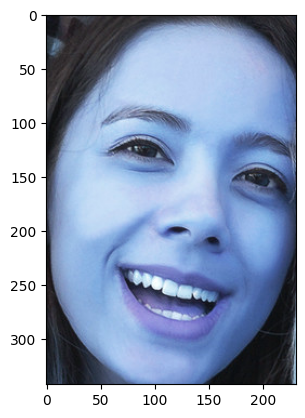

In [ ]:
plt.imshow(img_t)
plt.show()

In [ ]:
def get_faces_and_emotions(img_path: str, face_detector: YOLO,
                    emotion_classifier: nn.Module, problematic_emotion_classifier: nn.Module,
                     transforms: torchvision.transforms,
                    emotion_labels: list, problematic_emotions_labels: list,
                    threshold:int = 0.5,
                    device:str = 'cpu' ):

  image = cv.imread(img_path)
  faces,face_locations = find_faces(img_path, face_detector)
  labels = []
  for index,face in enumerate(faces):
    face = Image.fromarray(face)
    emotion = predict_emotion(emotion_classifier, problematic_emotion_classifier, face, transforms, emotions, problematic_emotions)
    corners = face_locations[img_path + str(index)]
    x1,x2,y1,y2 = corners[0], corners[1], corners[2], corners[3]
    labels.append(emotion)
    cv.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
    cv.putText(image, emotion,(int(x1) + 40 ,int(y1)), cv.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv.LINE_AA)

  plt.imshow(image)
  plt.show()
  return labels


image 1/1 /content/people1.jpg: 448x640 9 faces, 156.6ms
Speed: 3.3ms preprocess, 156.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


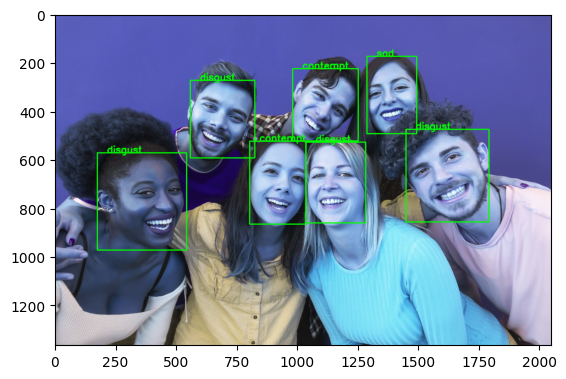

In [ ]:
labels = get_faces_and_emotions('/content/people1.jpg',face_detector,emotion_classifier, problematic_emotions_classifier,data_transform,emotions,problematic_emotions)

In [ ]:
labels